In [69]:
import pandas as pd

# Load all files (they should be in the same folder)
products = pd.read_csv("product_master_sample.csv", parse_dates=["launch_date"])
sales = pd.read_csv("sales_data_sample.csv", parse_dates=["date"])
marketing = pd.read_csv("marketing_spend_sample.csv")
logistics = pd.read_csv("logistics_cost_sample.csv")
customers = pd.read_csv("customer_data_sample.csv", parse_dates=["signup_date"])
ab_tests = pd.read_csv("ab_test_flags_sample.csv", parse_dates=["start_date", "end_date"])

print("All files loaded ✅")


All files loaded ✅


In [70]:
# Let's inspect Products
print("Shape (rows, columns):", products.shape)
print("Top 5 rows:")
print(products.head())
print("Info:")
print(products.info())


Shape (rows, columns): (10000, 5)
Top 5 rows:
  product_id  unit_cost     mrp        category launch_date
0  SKU-00001     218.54  436.28         Grocery  2024-03-05
1  SKU-00002     477.82  399.62     Electronics  2024-01-08
2  SKU-00003     379.40  258.54         Apparel  2024-09-13
3  SKU-00004     319.40  646.54  Home & Kitchen  2025-03-28
4  SKU-00005     120.21  528.96         Apparel  2023-07-04
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   product_id   10000 non-null  object        
 1   unit_cost    10000 non-null  float64       
 2   mrp          10000 non-null  float64       
 3   category     10000 non-null  object        
 4   launch_date  10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 390.8+ KB
None


In [71]:
print(products.isnull().sum())
print(sales.isnull().sum())
# Repeat for other dataframes...


product_id     0
unit_cost      0
mrp            0
category       0
launch_date    0
dtype: int64
sale_id          0
product_id       0
channel          0
region           0
quantity         0
discount_pct     0
returned_flag    0
date             0
customer_id      0
dtype: int64


In [72]:
print(products["category"].value_counts())


category
Electronics       2971
Home & Kitchen    2068
Apparel           2007
Grocery           1966
Beauty             988
Name: count, dtype: int64


In [73]:
print(sales["channel"].value_counts(normalize=True))
print("Return Rate:", sales["returned_flag"].mean())


channel
Online       0.60086
Retail       0.29968
Wholesale    0.09946
Name: proportion, dtype: float64
Return Rate: 0.05024


In [74]:
print(marketing["strategy_code"].value_counts())
print(customers["churn_flag"].mean())
print(customers["segment"].value_counts())


strategy_code
Email         2548
Influencer    2495
TV-Ad         2485
PPC           2472
Name: count, dtype: int64
0.1478
segment
Low-Value       3373
High-Value      3344
Medium-Value    3283
Name: count, dtype: int64


In [75]:
# Find the product_id with the most sales in the sales table
top_product_id = sales["product_id"].value_counts().idxmax()

# Get the corresponding product details from the products table
top_product_details = products[products["product_id"] == top_product_id]

print("Product with the most sales:")
print(top_product_details)

Product with the most sales:
     product_id  unit_cost    mrp category launch_date
1819  SKU-01820     221.87  378.6   Beauty  2025-02-22


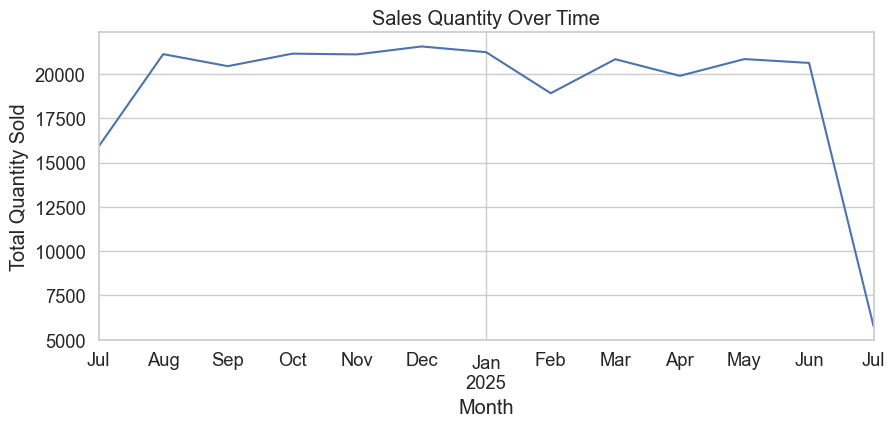

In [76]:
import matplotlib.pyplot as plt

sales["month"] = sales["date"].dt.to_period("M")
monthly_sales = sales.groupby("month")["quantity"].sum()

monthly_sales.plot(kind='line', figsize=(10,4), title="Sales Quantity Over Time")
plt.ylabel("Total Quantity Sold")
plt.xlabel("Month")
plt.grid(True)
plt.show()


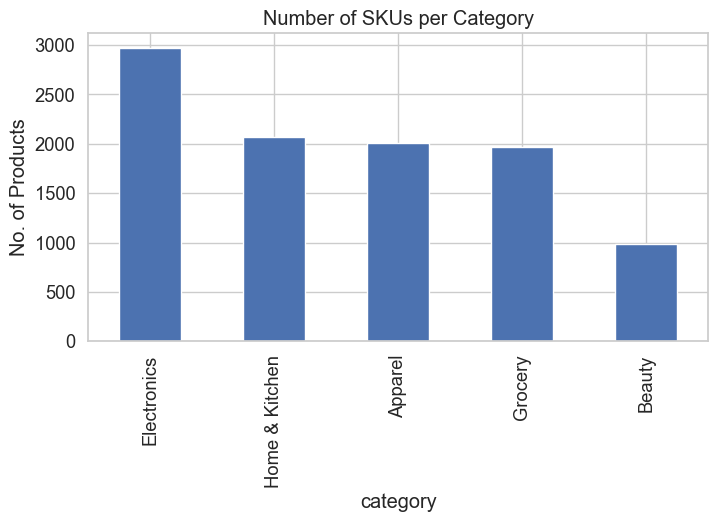

In [77]:
product_counts = products["category"].value_counts()
product_counts.plot(kind="bar", title="Number of SKUs per Category", figsize=(8,4))
plt.ylabel("No. of Products")
plt.grid(True)
plt.show()



In [78]:
# Merge
sales_full = sales.merge(products[["product_id", "unit_cost", "mrp"]], on="product_id", how="left")

# Compute revenue and cost
sales_full["net_price"] = sales_full["mrp"] * (1 - sales_full["discount_pct"])
sales_full["revenue"] = sales_full["net_price"] * sales_full["quantity"]
sales_full["cost"] = sales_full["unit_cost"] * sales_full["quantity"]
sales_full["gross_profit"] = sales_full["revenue"] - sales_full["cost"]

sales_full.head()


,sale_id,product_id,channel,region,quantity,discount_pct,returned_flag,date,customer_id,month,unit_cost,mrp,net_price,revenue,cost,gross_profit
0,SALE-0000001,SKU-08198,Retail,North,3,0.18,0,2025-02-24,CUST-001825,2025-02,180.31,782.03,641.2646,1923.7938,540.93,1382.8638
1,SALE-0000002,SKU-07821,Online,South,3,0.02,0,2024-07-10,CUST-000410,2024-07,209.49,835.61,818.8978,2456.6934,628.47,1828.2234
2,SALE-0000003,SKU-08141,Online,South,4,0.13,0,2025-03-24,CUST-004507,2025-03,104.12,407.40,354.4380,1417.7520,416.48,1001.2720
3,SALE-0000004,SKU-00532,Wholesale,North,5,0.47,0,2025-02-22,CUST-004013,2025-02,499.87,782.91,414.9423,2074.7115,2499.35,-424.6385
4,SALE-0000005,SKU-08017,Online,East,9,0.49,0,2025-01-25,CUST-003658,2025-01,262.95,573.21,292.3371,2631.0339,2366.55,264.4839


In [79]:
# Convert to period format
sales_full["month"] = pd.to_datetime(sales_full["date"]).dt.to_period("M")
marketing["month"] = pd.to_datetime(marketing["month"]).dt.to_period("M")


In [80]:
# Merge on product_id, channel, month
sales_full = sales_full.merge(
    marketing[["product_id", "channel", "month", "marketing_spend"]],
    on=["product_id", "channel", "month"],
    how="left"
)

# Replace missing spend with 0
sales_full["marketing_spend"] = sales_full["marketing_spend"].fillna(0)

# Distribute spend per unit (simple average)
sales_full["marketing_cost"] = sales_full["marketing_spend"] / sales_full["quantity"]


In [81]:
import numpy as np
np.random.seed(42)

# Random shipment assignment
sales_full["shipment_id"] = np.random.choice(logistics["shipment_id"], size=len(sales_full))

# Merge shipment cost
sales_full = sales_full.merge(logistics[["shipment_id", "shipment_cost"]], on="shipment_id", how="left")
sales_full["shipment_cost"] = sales_full["shipment_cost"].fillna(0)


In [82]:
# Add all business costs
sales_full["true_cost"] = (
    sales_full["cost"] +
    sales_full["marketing_cost"] +
    sales_full["shipment_cost"]
)

# True profit
sales_full["true_profit"] = sales_full["revenue"] - sales_full["true_cost"]


In [83]:
# Merge with customer churn
sales_full = sales_full.merge(customers[["customer_id", "churn_flag"]], on="customer_id", how="left")

# Adjust profit if churned
sales_full["churn_weighted_profit"] = np.where(
    sales_full["churn_flag"] == 1,
    sales_full["true_profit"] * 0.5,
    sales_full["true_profit"]
)


In [84]:
summary = sales_full.groupby(["product_id", "region", "channel"]).agg({
    "revenue": "sum",
    "true_cost": "sum",
    "true_profit": "sum",
    "churn_weighted_profit": "sum",
    "quantity": "sum"
}).reset_index()

summary["profit_per_unit"] = summary["true_profit"] / summary["quantity"]
summary["churn_penalty"] = summary["true_profit"] - summary["churn_weighted_profit"]

print("Summary table created ✅")
summary.head()


Summary table created ✅


,product_id,region,channel,revenue,true_cost,true_profit,churn_weighted_profit,quantity,profit_per_unit,churn_penalty
0,SKU-00001,East,Wholesale,2120.3208,2264.89,-144.5692,-144.5692,9,-16.063244,0.000
1,SKU-00001,North,Online,994.7184,1079.69,-84.9716,-84.9716,4,-21.242900,0.000
2,SKU-00001,North,Retail,3350.6304,3400.00,-49.3696,8.1824,13,-3.797662,-57.552
3,SKU-00001,South,Online,4345.3488,4340.53,4.8188,4.8188,16,0.301175,0.000
4,SKU-00001,West,Retail,3311.3652,2875.86,435.5052,435.5052,9,48.389467,0.000


In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean style
sns.set(style="whitegrid")


C:\Users\HP\AppData\Local\Temp\ipykernel_6496\521819088.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_profit, x="product_id", y="true_profit", palette="Greens_r")
C:\Users\HP\AppData\Local\Temp\ipykernel_6496\521819088.py:7: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\HP\OneDrive\Desktop\Profitability\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


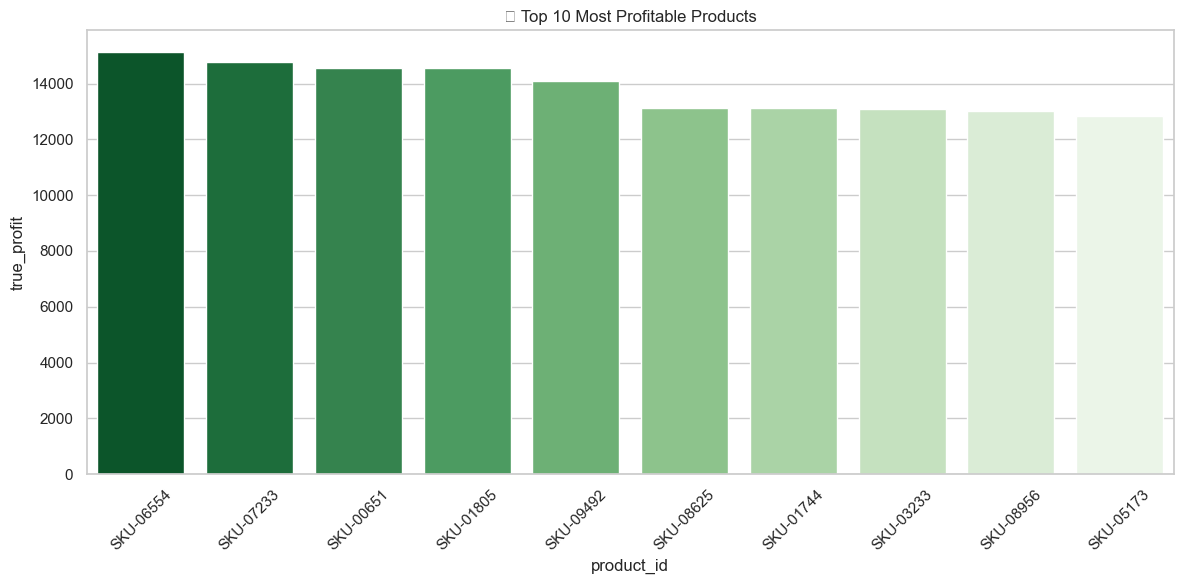

In [86]:
top_profit = summary.sort_values("true_profit", ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top_profit, x="product_id", y="true_profit", palette="Greens_r")
plt.title("💰 Top 10 Most Profitable Products")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_6496\3017633034.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_profit, x="product_id", y="true_profit", palette="Reds_r")
C:\Users\HP\AppData\Local\Temp\ipykernel_6496\3017633034.py:7: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\HP\OneDrive\Desktop\Profitability\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


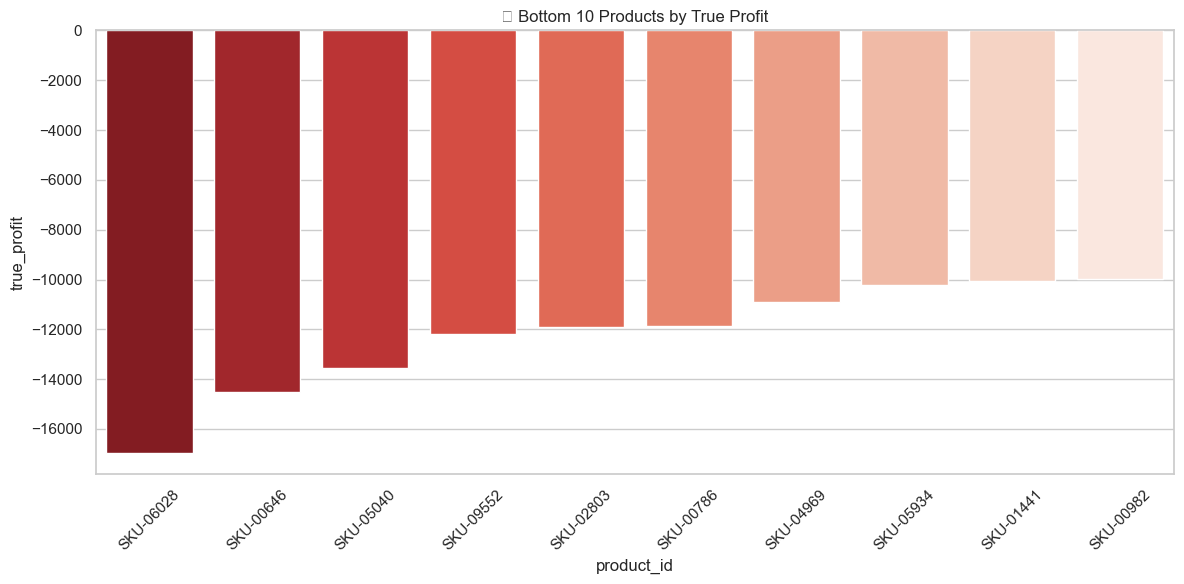

In [87]:
bottom_profit = summary.sort_values("true_profit").head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=bottom_profit, x="product_id", y="true_profit", palette="Reds_r")
plt.title("🚨 Bottom 10 Products by True Profit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_6496\3119799871.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_profit, x="region", y="profit_per_unit", palette="Blues")
c:\Users\HP\OneDrive\Desktop\Profitability\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


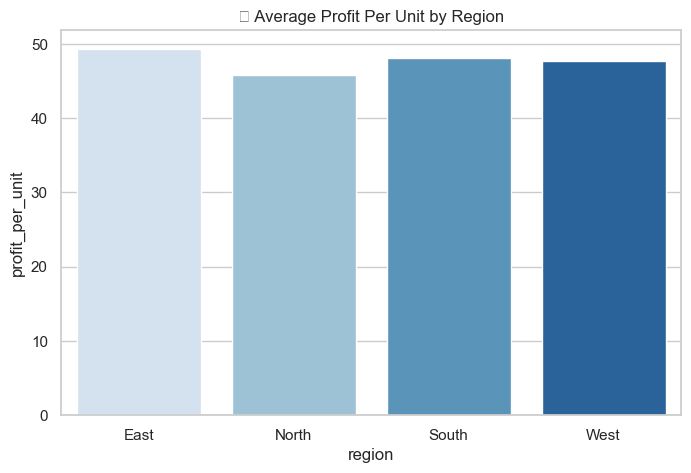

In [88]:
region_profit = summary.groupby("region")["profit_per_unit"].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=region_profit, x="region", y="profit_per_unit", palette="Blues")
plt.title("🌍 Average Profit Per Unit by Region")
plt.show()



C:\Users\HP\AppData\Local\Temp\ipykernel_6496\3538692697.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=roi, x="channel", y="marketing_roi", palette="Purples")
C:\Users\HP\AppData\Local\Temp\ipykernel_6496\3538692697.py:33: UserWarning: Glyph 128227 (\N{CHEERING MEGAPHONE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\HP\OneDrive\Desktop\Profitability\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128227 (\N{CHEERING MEGAPHONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


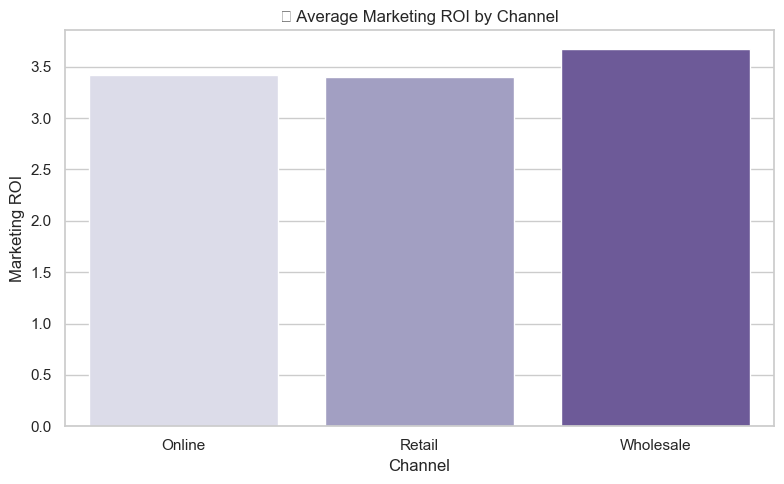

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 👇 Ensure sales_full exists from earlier steps (with all cost/profit columns)
# Now regenerate summary correctly

summary = sales_full.groupby(["product_id", "region", "channel"]).agg({
    "revenue": "sum",
    "cost": "sum",                        # ✅ FIX: Add this missing column
    "true_cost": "sum",
    "true_profit": "sum",
    "churn_weighted_profit": "sum",
    "quantity": "sum"
}).reset_index()

# Additional metrics
summary["profit_per_unit"] = summary["true_profit"] / summary["quantity"]
summary["churn_penalty"] = summary["true_profit"] - summary["churn_weighted_profit"]

# ✅ Calculate marketing ROI = true_profit / (marketing + logistics)
summary["marketing_roi"] = summary["true_profit"] / (summary["true_cost"] - summary["cost"])

# Group by channel to get average ROI
roi = summary.groupby("channel")["marketing_roi"].mean().reset_index()

# ✅ Plotting
plt.figure(figsize=(8,5))
sns.barplot(data=roi, x="channel", y="marketing_roi", palette="Purples")
plt.title("📣 Average Marketing ROI by Channel")
plt.xlabel("Channel")
plt.ylabel("Marketing ROI")
plt.tight_layout()
plt.show()



C:\Users\HP\AppData\Local\Temp\ipykernel_6496\1659939282.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=channel_roi, x="channel", y="ROI", palette="Purples")
C:\Users\HP\AppData\Local\Temp\ipykernel_6496\1659939282.py:17: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\HP\OneDrive\Desktop\Profitability\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


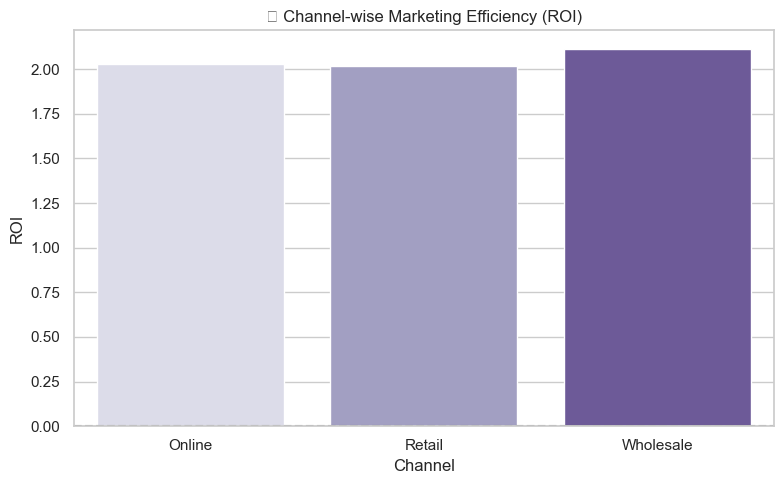

In [90]:
# Calculate channel-wise marketing efficiency (ROI)
# ROI = (Total True Profit - Total Marketing Spend) / Total Marketing Spend

channel_roi = sales_full.groupby("channel").agg({
    "true_profit": "sum",
    "marketing_spend": "sum"
}).reset_index()

channel_roi["ROI"] = (channel_roi["true_profit"] - channel_roi["marketing_spend"]) / channel_roi["marketing_spend"]

plt.figure(figsize=(8,5))
sns.barplot(data=channel_roi, x="channel", y="ROI", palette="Purples")
plt.title("📈 Channel-wise Marketing Efficiency (ROI)")
plt.ylabel("ROI")
plt.xlabel("Channel")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_6496\1960260972.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_penalty, x="region", y="churn_penalty", palette="Oranges")
c:\Users\HP\OneDrive\Desktop\Profitability\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128565 (\N{DIZZY FACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


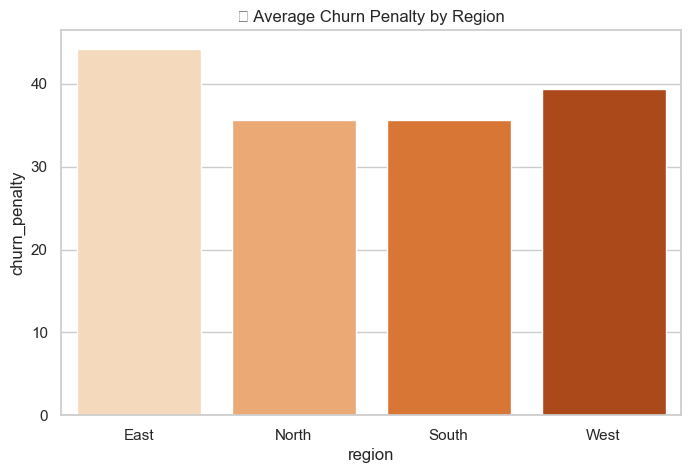

In [91]:
churn_penalty = summary.groupby("region")["churn_penalty"].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=churn_penalty, x="region", y="churn_penalty", palette="Oranges")
plt.title("😵 Average Churn Penalty by Region")
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_6496\1068611379.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(monthly["month"].dt.strftime("%b-%Y"), rotation=45)
C:\Users\HP\AppData\Local\Temp\ipykernel_6496\1068611379.py:18: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\HP\OneDrive\Desktop\Profitability\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


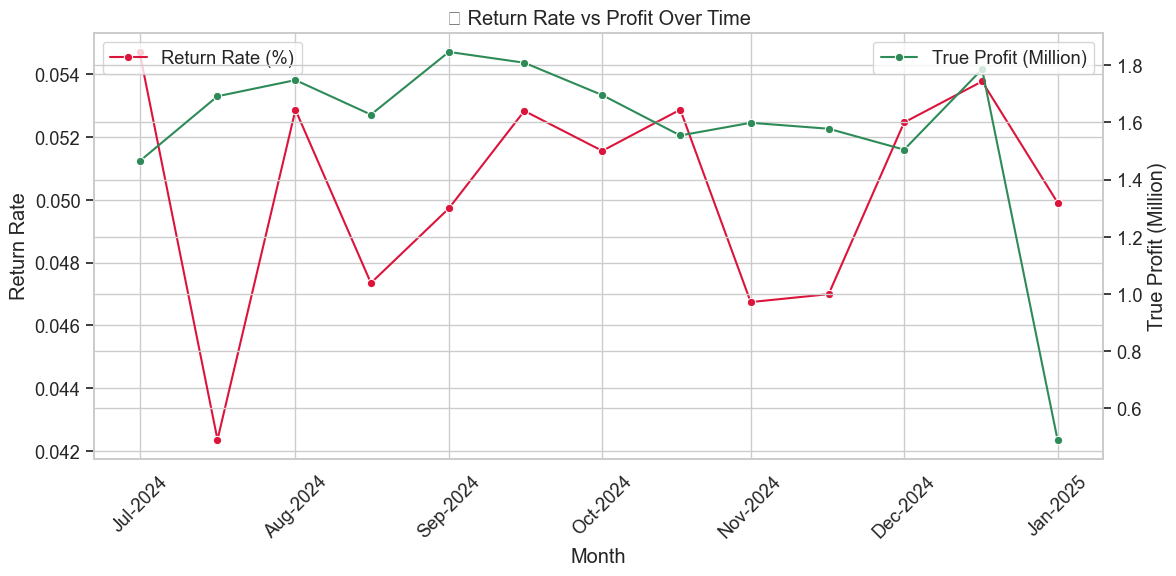

In [92]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", font_scale=1.2)

# Normalize profit for dual y-axis effect (optional, for visual balance)
profit = monthly["true_profit"] / 1e6  # in millions

ax = sns.lineplot(data=monthly, x="month", y="returned_flag", label="Return Rate (%)", color="crimson", marker="o")
ax2 = ax.twinx()
sns.lineplot(data=monthly, x="month", y=profit, label="True Profit (Million)", color="seagreen", marker="o", ax=ax2)

ax.set_ylabel("Return Rate")
ax2.set_ylabel("True Profit (Million)")
ax.set_xlabel("Month")
ax.set_title("📈 Return Rate vs Profit Over Time")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
ax.set_xticklabels(monthly["month"].dt.strftime("%b-%Y"), rotation=45)
plt.tight_layout()
plt.show()


In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# We'll use X_all (features) and y (target) for modeling
# Split into train/test if not already split
if 'X_train' not in locals() or 'X_test' not in locals():
    X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

# Train logistic regression
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8541
           1       0.00      0.00      0.00      1463

    accuracy                           0.85     10004
   macro avg       0.43      0.50      0.46     10004
weighted avg       0.73      0.85      0.79     10004

ROC AUC: 0.5055846980865005


c:\Users\HP\OneDrive\Desktop\Profitability\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HP\OneDrive\Desktop\Profitability\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HP\OneDrive\Desktop\Profitability\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

# Select features for modeling
model_features = ['revenue', 'ltv', 'channel', 'region', 'acquisition_source', 'segment']

# Prepare X and y
X = model_df[model_features]
y = model_df['churn_flag']

# Separate numeric and categorical columns
num_features = ['revenue', 'ltv']
cat_features = ['channel', 'region', 'acquisition_source', 'segment']

# Scale numeric features
scaler = StandardScaler()
X_num = scaler.fit_transform(X[num_features])

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat = encoder.fit_transform(X[cat_features])

# Combine features
X_all = np.hstack([X_num, X_cat])

# Train logistic regression
clf = LogisticRegression(max_iter=500)
clf.fit(X_all, y)

# Predict churn probability for all customers
model_df['churn_prob'] = clf.predict_proba(X_all)[:, 1]

# Estimate expected profit: expected_profit = true_profit * (1 - churn_prob)
model_df['expected_profit'] = model_df['true_profit'] * (1 - model_df['churn_prob'])

# Calculate expected profit loss
model_df['expected_profit_loss'] = model_df['true_profit'] - model_df['expected_profit']

# Aggregate by customer to get total expected profit loss per customer
customer_loss = model_df.groupby('customer_id').agg({
    'expected_profit_loss': 'sum',
    'expected_profit': 'sum',
    'true_profit': 'sum',
    'churn_prob': 'mean'
}).reset_index()

# Sort by expected profit loss descending
top_loss = customer_loss.sort_values('expected_profit_loss', ascending=False).head(10)

# Display
print("Top 10 customers with highest expected profit loss due to churn risk:")
print(top_loss[['customer_id', 'expected_profit_loss', 'true_profit', 'expected_profit', 'churn_prob']])

Top 10 customers with highest expected profit loss due to churn risk:
      customer_id  expected_profit_loss  true_profit  expected_profit  \
81    CUST-000082           3053.189470   18928.3784     15875.188930   
9022  CUST-009080           2995.885130   19200.0772     16204.192070   
1867  CUST-001880           2934.599379   20360.7349     17426.135521   
6316  CUST-006356           2896.436148   18291.9602     15395.524052   
6655  CUST-006698           2876.814445   18349.3624     15472.547955   
8688  CUST-008744           2786.992467   17886.3677     15099.375233   
2092  CUST-002106           2573.885421   18050.7959     15476.910479   
7036  CUST-007082           2421.154485   16770.5646     14349.410115   
9363  CUST-009425           2374.177811   15971.1396     13596.961789   
4687  CUST-004719           2365.002463   15239.4018     12874.399337   

      churn_prob  
81      0.160333  
9022    0.156221  
1867    0.142329  
6316    0.157025  
6655    0.156357  
8688    0.15

Churn Rate t-test (Control vs Variation A): p = 0.004307105669839617
Churn Rate t-test (Control vs Variation B): p = 0.4248252405801941
Revenue t-test (Control vs Variation A): p = 0.7036158892078743
Revenue t-test (Control vs Variation B): p = 0.4941150331591364
Return Rate t-test (Control vs Variation A): p = 0.11152111229073185
Return Rate t-test (Control vs Variation B): p = 0.5559112541372591


C:\Users\HP\AppData\Local\Temp\ipykernel_6496\3617122679.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_metrics.index, y=group_metrics["churn_rate"], palette="Set2")
C:\Users\HP\AppData\Local\Temp\ipykernel_6496\3617122679.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_metrics.index, y=group_metrics["avg_revenue"], palette="Set2")
C:\Users\HP\AppData\Local\Temp\ipykernel_6496\3617122679.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_metrics.index, y=group_metrics["return_rate"], palette="Set2")


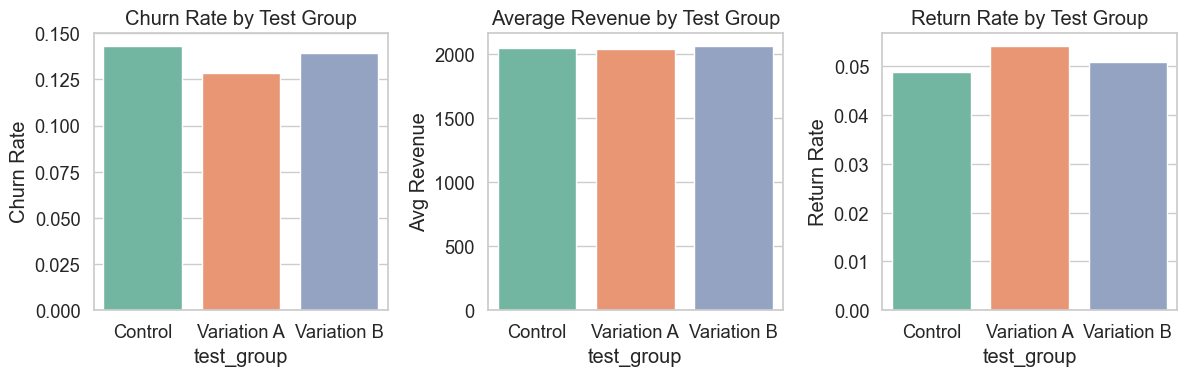

In [97]:
from scipy.stats import ttest_ind
import seaborn as sns

import matplotlib.pyplot as plt

# Group by test_group and calculate means for churn_rate, avg_revenue, return_rate
group_metrics = ab_summary.set_index("test_group")[["churn_rate", "avg_revenue", "return_rate"]]

# Prepare data for t-tests: get customer-level metrics by merging ab_tests with customers and model_df
ab_merged = ab_tests.merge(customers[["customer_id", "churn_flag"]], on="customer_id", how="left")
ab_merged = ab_merged.merge(model_df[["customer_id", "revenue", "returned_flag"]], on="customer_id", how="left")

# Churn rate t-test
control_churn = ab_merged[ab_merged["test_group"] == "Control"]["churn_flag"].dropna()
varA_churn = ab_merged[ab_merged["test_group"] == "Variation A"]["churn_flag"].dropna()
varB_churn = ab_merged[ab_merged["test_group"] == "Variation B"]["churn_flag"].dropna()

t_churn_A, p_churn_A = ttest_ind(control_churn, varA_churn, equal_var=False)
t_churn_B, p_churn_B = ttest_ind(control_churn, varB_churn, equal_var=False)

# Revenue t-test
control_rev = ab_merged[ab_merged["test_group"] == "Control"]["revenue"].dropna()
varA_rev = ab_merged[ab_merged["test_group"] == "Variation A"]["revenue"].dropna()
varB_rev = ab_merged[ab_merged["test_group"] == "Variation B"]["revenue"].dropna()

t_rev_A, p_rev_A = ttest_ind(control_rev, varA_rev, equal_var=False)
t_rev_B, p_rev_B = ttest_ind(control_rev, varB_rev, equal_var=False)

# Return rate t-test
control_ret = ab_merged[ab_merged["test_group"] == "Control"]["returned_flag"].dropna()
varA_ret = ab_merged[ab_merged["test_group"] == "Variation A"]["returned_flag"].dropna()
varB_ret = ab_merged[ab_merged["test_group"] == "Variation B"]["returned_flag"].dropna()

t_ret_A, p_ret_A = ttest_ind(control_ret, varA_ret, equal_var=False)
t_ret_B, p_ret_B = ttest_ind(control_ret, varB_ret, equal_var=False)

# Print t-test results
print("Churn Rate t-test (Control vs Variation A): p =", p_churn_A)
print("Churn Rate t-test (Control vs Variation B): p =", p_churn_B)
print("Revenue t-test (Control vs Variation A): p =", p_rev_A)
print("Revenue t-test (Control vs Variation B): p =", p_rev_B)
print("Return Rate t-test (Control vs Variation A): p =", p_ret_A)
print("Return Rate t-test (Control vs Variation B): p =", p_ret_B)

# Visualize metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.barplot(x=group_metrics.index, y=group_metrics["churn_rate"], palette="Set2")
plt.title("Churn Rate by Test Group")
plt.ylabel("Churn Rate")

plt.subplot(1, 3, 2)
sns.barplot(x=group_metrics.index, y=group_metrics["avg_revenue"], palette="Set2")
plt.title("Average Revenue by Test Group")
plt.ylabel("Avg Revenue")

plt.subplot(1, 3, 3)
sns.barplot(x=group_metrics.index, y=group_metrics["return_rate"], palette="Set2")
plt.title("Return Rate by Test Group")
plt.ylabel("Return Rate")

plt.tight_layout()
plt.show()

In [98]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans

# Select segmentation features
segmentation_features = ['ltv', 'churn_flag', 'region', 'segment', 'acquisition_source']

# Prepare data for clustering
X_seg = customers[segmentation_features].copy()

# One-hot encode categorical columns
cat_cols = ['region', 'segment', 'acquisition_source']
encoder_seg = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat_seg = encoder_seg.fit_transform(X_seg[cat_cols])

# Scale numeric columns
num_cols = ['ltv', 'churn_flag']
scaler_seg = StandardScaler()
X_num_seg = scaler_seg.fit_transform(X_seg[num_cols])

# Combine features
X_cluster = np.hstack([X_num_seg, X_cat_seg])

# KMeans clustering
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
customers['cluster'] = kmeans.fit_predict(X_cluster)

# Analyze clusters: mean churn and LTV per cluster
cluster_summary = customers.groupby('cluster').agg({
    'ltv': 'mean',
    'churn_flag': 'mean'
})

# Label clusters based on churn and LTV
def label_cluster(row):
    if row['churn_flag'] > 0.15 and row['ltv'] > cluster_summary['ltv'].median():
        return 'High LTV, High Churn'
    elif row['churn_flag'] > 0.15:
        return 'Low LTV, High Churn'
    elif row['ltv'] > cluster_summary['ltv'].median():
        return 'High LTV, Low Churn'
    else:
        return 'Low LTV, Low Churn'

cluster_summary['label'] = cluster_summary.apply(label_cluster, axis=1)
print(cluster_summary)

                 ltv  churn_flag                 label
cluster                                               
0        2666.440783         0.0    Low LTV, Low Churn
1        7738.974590         0.0   High LTV, Low Churn
2        3150.793756         0.0    Low LTV, Low Churn
3        5003.188945         1.0  High LTV, High Churn


C:\Users\HP\AppData\Local\Temp\ipykernel_6496\3406496742.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(monthly_cust["month"].dt.strftime("%b-%Y"), rotation=45)


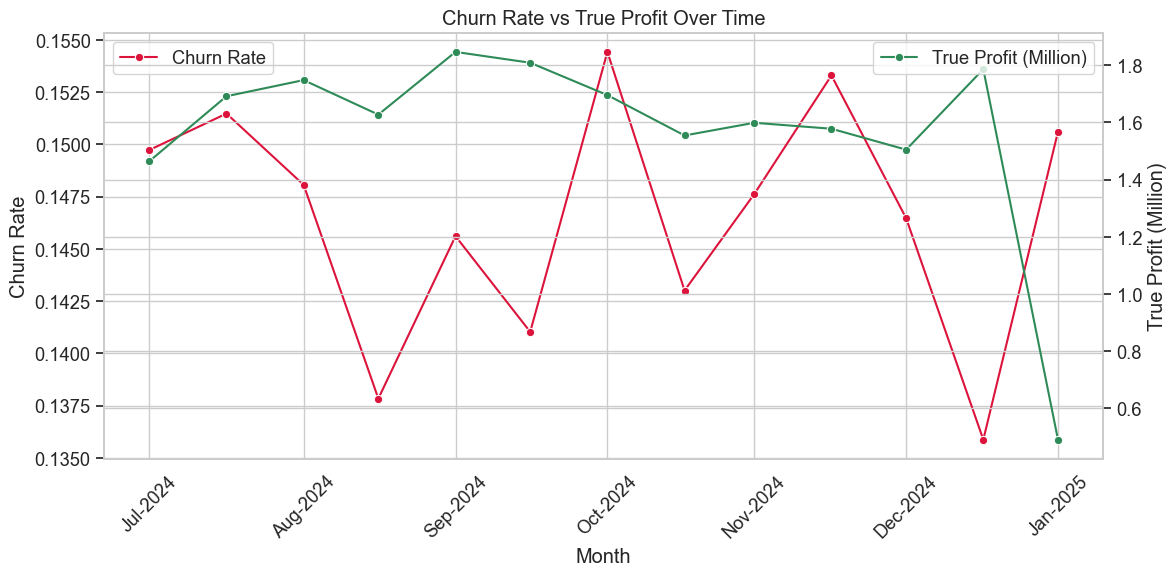

In [99]:
# Group by month: calculate churn rate and sum true profit
monthly_cust = model_df.groupby(model_df["month"].dt.to_period("M")).agg({
    "churn_flag": "mean",
    "true_profit": "sum"
}).reset_index()
monthly_cust["month"] = monthly_cust["month"].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", font_scale=1.2)

ax = sns.lineplot(data=monthly_cust, x="month", y="churn_flag", label="Churn Rate", color="crimson", marker="o")
ax2 = ax.twinx()
sns.lineplot(data=monthly_cust, x="month", y=monthly_cust["true_profit"] / 1e6, label="True Profit (Million)", color="seagreen", marker="o", ax=ax2)

ax.set_ylabel("Churn Rate")
ax2.set_ylabel("True Profit (Million)")
ax.set_xlabel("Month")
ax.set_title("Churn Rate vs True Profit Over Time")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
ax.set_xticklabels(monthly_cust["month"].dt.strftime("%b-%Y"), rotation=45)
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_6496\2762091414.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_summary, x="segment", y="avg_true_profit", palette="Blues")
C:\Users\HP\AppData\Local\Temp\ipykernel_6496\2762091414.py:20: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\HP\OneDrive\Desktop\Profitability\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


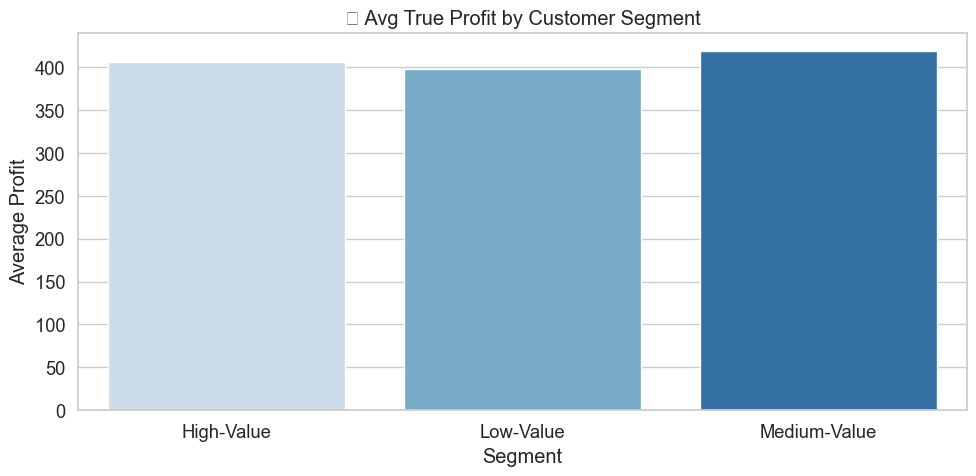

        segment  avg_true_profit  churn_rate  avg_revenue
0    High-Value       406.141717    0.150297  2071.622603
1     Low-Value       397.899187    0.149222  2058.969189
2  Medium-Value       419.313286    0.138990  2069.761154


In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# Segment-wise Profitability
segment_summary = model_df.groupby("segment").agg({
    "true_profit": "mean",
    "churn_flag": "mean",
    "revenue": "mean"
}).reset_index()

# Rename columns for clarity
segment_summary.columns = ["segment", "avg_true_profit", "churn_rate", "avg_revenue"]

# Plot
plt.figure(figsize=(10,5))
sns.barplot(data=segment_summary, x="segment", y="avg_true_profit", palette="Blues")
plt.title("💰 Avg True Profit by Customer Segment")
plt.ylabel("Average Profit")
plt.xlabel("Segment")
plt.tight_layout()
plt.show()

print(segment_summary)


C:\Users\HP\AppData\Local\Temp\ipykernel_6496\4068813334.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\HP\OneDrive\Desktop\Profitability\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


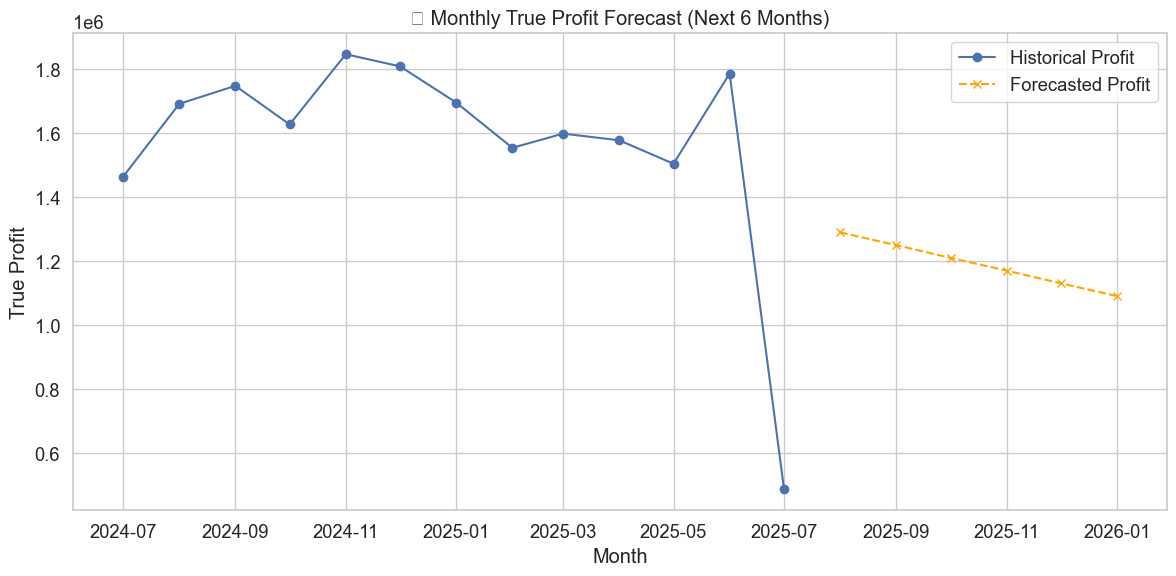

In [112]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# Ensure 'date' column exists in sales_full and is datetime
sales_full["month"] = sales_full["date"].dt.to_period("M").dt.to_timestamp()
monthly_profit = sales_full.groupby("month")["true_profit"].sum().reset_index()

# Prepare data for forecasting
monthly_profit["month_number"] = np.arange(len(monthly_profit))  # Treat month as a number
X = monthly_profit[["month_number"]]
y = monthly_profit["true_profit"]

# Train simple linear model
model = LinearRegression()
model.fit(X, y)

# Forecast next 6 months
future_months = pd.DataFrame({
    "month_number": np.arange(len(monthly_profit), len(monthly_profit) + 6)
})
forecast = model.predict(future_months)

# Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_profit["month"], y, marker='o', label="Historical Profit")
future_dates = pd.date_range(start=monthly_profit["month"].iloc[-1] + pd.offsets.MonthBegin(1), periods=6, freq='MS')
plt.plot(future_dates, forecast, marker='x', linestyle='--', color="orange", label="Forecasted Profit")
plt.title("📈 Monthly True Profit Forecast (Next 6 Months)")
plt.xlabel("Month")
plt.ylabel("True Profit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
